+ **NOTE:** This notebook is trained on Google Colaboratory

## Importing Libraries

In [0]:
import tensorflow as tf

import os
import zipfile
import random
import numpy as np
import re
import shutil

import matplotlib.image as mpImg
import matplotlib.pyplot as plt
%matplotlib inline

## Analyzing Dataset

In [0]:
# # This code block downloads the full Cats-v-Dogs dataset and stores it as 
# # cats-and-dogs.zip. It then unzips it to /tmp
# # which will create a tmp/PetImages directory containing subdirectories
# # called 'Cat' and 'Dog' (that's how the original researchers structured it)
# # If the URL doesn't work, 
# # .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# # And right click on the 'Download Manually' link to get a new URL

# !wget --no-check-certificate \
#     "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
#     -O "/tmp/cats-and-dogs.zip"

In [0]:
local_training_zip = '/content/drive/My Drive/Colab Notebooks/dogs-vs-cats.zip'
if zipfile.is_zipfile(local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r')
    zip_ref.extractall('/tmp/')
    zip_ref.close()

train_training_zip = '/tmp/train.zip'
if zipfile.is_zipfile(local_training_zip):
    zip_ref = zipfile.ZipFile(file=train_training_zip, mode='r')
    zip_ref.extractall('/tmp/data/')
    zip_ref.close()

test_training_zip = '/tmp/test1.zip'
if zipfile.is_zipfile(local_training_zip):
    zip_ref = zipfile.ZipFile(file=test_training_zip, mode='r')
    zip_ref.extractall('/tmp/data/')
    zip_ref.close()

In [4]:
os.listdir('/tmp/data/train/')[:10]

['dog.9893.jpg',
 'dog.3943.jpg',
 'dog.5252.jpg',
 'cat.10520.jpg',
 'dog.2159.jpg',
 'dog.6939.jpg',
 'cat.6069.jpg',
 'dog.9081.jpg',
 'cat.11120.jpg',
 'cat.998.jpg']

In [5]:
len(os.listdir('/tmp/data/train/'))

25000

In [6]:
c, d = 0, 0
for i in os.listdir('/tmp/data/train/'):
    if(i[0]=='c'):
        c += 1
    else:
        d += 1

print('No. of Cats:', c)
print('No. of Dogs:', d)

No. of Cats: 12500
No. of Dogs: 12500


In [7]:
len(os.listdir('/tmp/data/test1/'))

12500

In [0]:
random_list = random.sample(range(12500), 3125)
os.makedirs('/tmp/data/validation/dogs')
os.makedirs('/tmp/data/validation/cats')
for i in random_list:
    fn = 'dog.'+str(i)+'.jpg'
    shutil.move('/tmp/data/train/'+fn, '/tmp/data/validation/dogs/'+fn)
    fn = 'cat.'+str(i)+'.jpg'
    shutil.move('/tmp/data/train/'+fn, '/tmp/data/validation/cats/'+fn)

remaining = os.listdir('/tmp/data/train/')
os.mkdir('/tmp/data/train/dogs')
os.mkdir('/tmp/data/train/cats')
for i in remaining:
    if(i[0]=='d'):
        shutil.move('/tmp/data/train/'+i, '/tmp/data/train/dogs/'+i)
    else:
        shutil.move('/tmp/data/train/'+i, '/tmp/data/train/cats/'+i)

**Image Distribution:**
+ Training Set
    - Dogs: 0.75*12500=9375
    - Cats: 0.75*12500=9375
+ Validating Set
    - Dogs: 0.25*12500=3125
    - Cats: 0.25*12500=3125
+ Testing Set: 12500

Random 5 images of dogs and cats each from training set


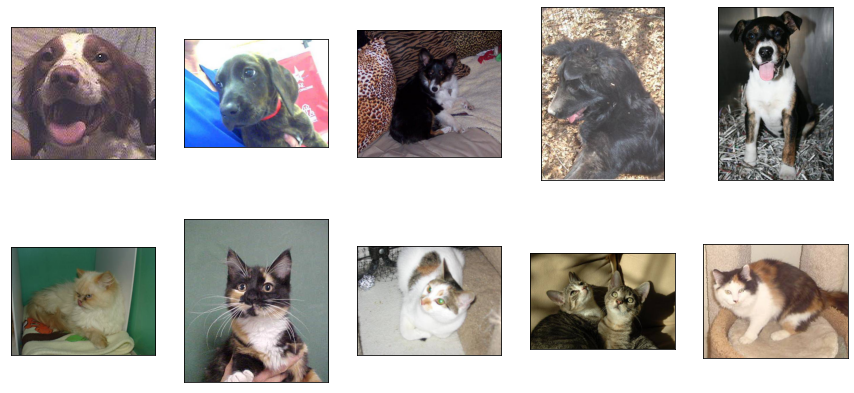

In [9]:
print('Random 5 images of dogs and cats each from training set')
plt.figure(figsize=(15, 7))
i = 1
while(i<6):
    img_name = random.choice(os.listdir('/tmp/data/train/dogs/'))
    img = mpImg.imread('/tmp/data/train/dogs/' + img_name)
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    
    img_name = random.choice(os.listdir('/tmp/data/train/cats/'))
    img = mpImg.imread('/tmp/data/train/cats/' + img_name)
    plt.subplot(2, 5, 5+i)
    plt.imshow(img)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    
    i += 1

## Creating the Model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

## Model Summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

## Compiling the Model

In [0]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

## Importing Images from Directories

In [13]:
# Training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/tmp/data/train/',
    target_size=(300, 300),
    batch_size=25,
    class_mode='binary'
)

# Validation data
validate_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

validate_generator = validate_datagen.flow_from_directory(
    '/tmp/data/validation/',
    target_size=(300, 300),
    batch_size=25,
    class_mode='binary'
)

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


## Setting the Callback for the Model

In [0]:
# callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/model/cp.ckpt',
                                                 monitor='val_loss',
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 save_freq='epoch',
                                                 verbose=1)

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

## Training the Model

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=750,
    epochs=15,
    validation_data=validate_generator,
    validation_steps=250,
    verbose=1,
    callbacks=[early_stopping, cp_callback]
)

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 0.6949 - acc: 0.5599
Epoch 00001: val_loss improved from inf to 0.65622, saving model to /content/drive/My Drive/Colab Notebooks/model/cp.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model/cp.ckpt/assets
750/750 [==============================] - 149s 199ms/step - loss: 0.6949 - acc: 0.5599 - val_loss: 0.6562 - val_acc: 0.6093
Epoch 2/15
750/750 [==============================] - ETA: 0s - loss: 0.6140 - acc: 0.6618
Epoch 00002: val_loss improved from 0.65622 to 0.56635, saving model to /content/drive/My Drive/Colab Notebooks/model/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model/cp.ckpt/assets
750/750 [==============================] - 149s 199ms/step - loss: 0.6140 - acc: 0.6618 - val_loss: 0.5664 - val_acc: 0.7090
Epoch 3/15
750/750 [===========================

## Analyzing the Trained Model

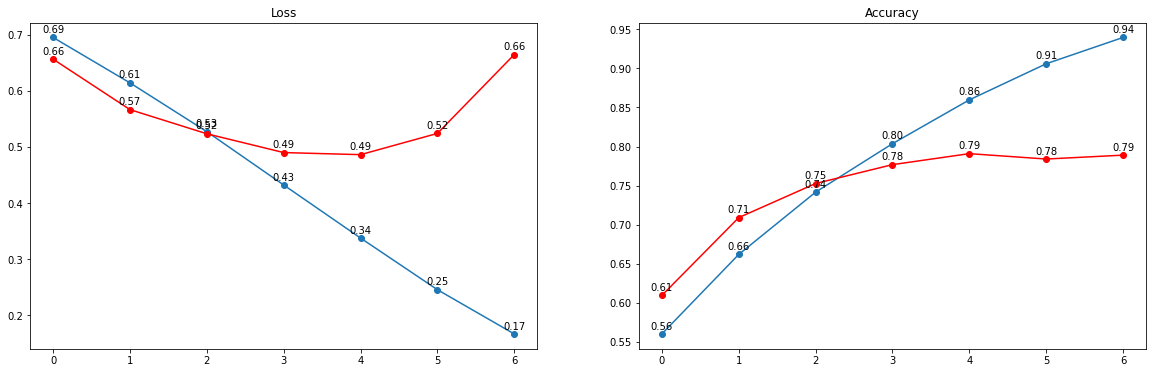

In [17]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o')
plt.title('Loss')
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['loss']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.plot(history.history['val_loss'], color='r', marker='o')
plt.title('Loss')
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['val_loss']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], marker='o')
plt.title('Accuracy')
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['acc']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.plot(history.history['val_acc'], color='r', marker='o')
plt.title('Accuracy')
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['val_acc']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

## Class Indices for Model

In [18]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

## Testing the Model against a Image

In [0]:
# loading best saved model
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/model/cp.ckpt')

In [0]:
# custom image path from directory
img_path = '/content/drive/My Drive/Colab Notebooks/cat1.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(300, 300), color_mode='rgb')
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = img_tensor/255.0

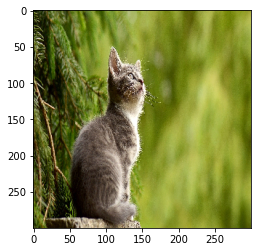

In [21]:
plt.imshow(img_tensor.reshape(300, 300, 3))

In [0]:
img_tensor = np.expand_dims(img_tensor, axis=0)

In [23]:
if model.predict(img_tensor)>0.5:
    print('Dog')
else:
    print('Cat')

Cat
